# **BSP Project: ECG signal decomposition using Fourier analysis**

*   **Author:** Matteo Onger
*   **Date:** February 2025

**Documentation**:
*   Paper: [ECG signal decomposition using Fourier analysis](https://doi.org/10.1186/s13634-024-01171-x)
*   Dataset: [Lobachevsky University Electrocardiography Database](https://www.physionet.org/content/ludb/1.0.1/)
*   Python packages: [WFDB](https://pypi.org/project/wfdb/)

**Notes**:
*   For faster execution, please use a gpu-equipped runtime.

In [ ]:
# install library
!pip install wfdb

In [2]:
# ---- LIBRARIES ----
import importlib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import wfdb

from enum import Enum


# set logger
logging.basicConfig(format="%(asctime)s | %(levelname)s | %(name)s:%(funcName)s - %(message)s", level=logging.DEBUG, force=True)
logger = logging.getLogger(__name__)


# current runtime type, if gpu available use cupy else numpy
if os.environ["COLAB_GPU"] != "":
    GPU = True
    logger.info("GPU connected")
    logger.info("Load Cupy")
    ncp = importlib.import_module("cupy")
else:
    GPU = False
    logger.info("No accelerator connected")
    ncp = np

2025-01-25 00:22:04,556 | INFO | __main__:<cell line: 0> - No accelerator connected


In [3]:
# ---- FUNCTIONS ----
def dft_l1(x :ncp.ndarray, K :int, max_iters :int=5, eps :float|None=1e-6, fast_init :bool=True) -> ncp.ndarray:
    """
    Computes the l1 Fourier transform of a real signal ``x`` and returns the Fourier coefficients.
    The parameter ``K`` determines the number of Fourier coefficients to compute, so,
    if it is not equal to the length of ``x``, a truncated l1 Fourier trasform is computed.

    Parameters
    ----------
    x : numpy.ndarray | cupy.ndarray of shape \(N)
        Original signal, i.e. an array of ``N`` real numbers that are the samples collected.
    K : int
        Number of Fourier coefficients to compute.
    max_iters : int, optional
        Maximum number of iterations, by default is ``5``.
    eps : float | None, optional
        Tolerance for the convergence of the algorithm, by default is ``1e-6``.
        If ``None``, the algorithm will run until the maximum number of iterations is reached.
    fast_init : bool, optional
        If ``True``, the algorithm will use a faster initialization of the Fourier coefficients, by default is ``True``.

    Returns
    -------
    : numpy.ndarray | cupy.ndarray of shape \(K)
        The Fourier coefficients computed, i.e. an array of ``K`` complex numbers.

    Raises
    ------
    : ValueError
        If ``K != N`` and ``K > 1 + N//2``.

    Notes
    -----
    - If the input signal ``x`` contains complex numbers, only the real part is taken into account.
    """
    N = len(x)
    if (K != N) and (K > 1 + N//2):
        raise ValueError("<K> must be equal to the length of <x> or smaller/equal than half the length of <x> plus 1")

    logger.info(f"Start -> K={K}, max_iters={max_iters}, eps={eps}")

    # if gpu available, move data to the device
    isnumpy = isinstance(x, np.ndarray)
    if GPU and isnumpy:
        x = ncp.asarray(x)

    # keep only real part
    x = ncp.real(x)

    # total number of coefficients computed
    # including complex conjugates
    M = 2*K - 1 if K != N else K
    if (N % 2 == 0) and (K == 1 + N//2):
        M -= 1

    # fourier basis, matrix of shape (N,M) and its conjugate transpose
    fi = ncp.exp(ncp.array([[1j * (2 * ncp.pi * k / N) * n for k in range(K-M, K, 1)] for n in range(N)])) / ncp.sqrt(N)
    tconj_fi = ncp.transpose(ncp.conj(fi))

    # init fourier coefficients
    coeff = ncp.zeros(fi.shape[1], dtype=ncp.complex128)
    # reconstructed signal
    xk = x + 1 if fast_init else ncp.real(fi @ coeff)
    # previously recon. signal
    prev_xk = None

    for iter in range(max_iters):
        delta = ncp.abs(x - xk)
        delta = ncp.diag(1 / ncp.where(delta == 0, 1e-18, delta))

        # update fourier coefficients and prev. recon. signal and recon. signal
        coeff = ncp.linalg.inv(tconj_fi @ delta @ fi) @ tconj_fi @ delta @ x
        prev_xk = xk
        xk = ncp.real(fi @ coeff)

        # check convergency
        conv = np.mean(np.abs(xk - prev_xk))
        logger.debug(f"Iteration {iter+1} -> convergency={conv}")
        if (eps is not None) and (conv <= eps):
            break

    # compute final convergency and loss wrt original signal
    conv, loss = np.mean(np.abs(xk - prev_xk)), ncp.abs((x - xk) / np.where(x == 0, 1, x))
    logger.info(f"End -> iter={iter+1}, " +
        f"convergency={ncp.round(conv, 4)}, " +
        f"min_abs_loss={ncp.around(ncp.min(loss), 4)}, "  +
        f"avg_abs_loss={ncp.around(ncp.mean(loss), 4)}, " +
        f"max_abs_loss={ncp.around(ncp.max(loss), 4)}"
    )
    return ncp.asnumpy(coeff[-K:]) if GPU and isnumpy else coeff[-K:]


def idft_l1(coeff :ncp.ndarray, N :int, onlyreal :bool=False) -> ncp.ndarray:
    """
    Computes the inverse l1 Fourier transform of a real signal ``x`` given its Fourier coefficients ``coeff``
    and returns the reconstructed signal.

    Parameters
    ----------
    coeff : numpy.ndarray | cupy.ndarray of shape \(K)
        Fourier coefficients, i.e. an array of ``K`` complex numbers.
    N : int
        Length of the signal to reconstruct.
    onlyreal : bool, optional
        If ``True``, only the real part of the reconstructed signal is returned, by default is ``False``.

    Returns
    -------
    : numpy.ndarray | cupy.ndarray of shape \(N)
        The reconstructed signal, i.e. an array of ``N`` real numbers.

    Raises
    ------
    : ValueError
        If ``K != N`` and ``K > 1 + N//2``.
    """
    K = len(coeff)
    if (K != N) and (K > 1 + N//2):
        raise ValueError("the number of coefficients must be equal to <N> or smaller/equal than <N> half plus 1")

    # if gpu available, move data to the device
    isnumpy = isinstance(coeff, np.ndarray)
    if GPU and isnumpy:
        coeff = ncp.asarray(coeff)

    # total number of coefficients computed
    # including complex conjugates
    M = 2*K - 1 if K != N else K
    if (N % 2 == 0) and (K == 1 + N//2):
        M -= 1

    # fourier basis, matrix of shape (N,M)
    fi = ncp.exp(ncp.array([[1j * (2 * ncp.pi * k / N) * n for k in range(K-M, K, 1)] for n in range(N)])) / ncp.sqrt(N)

    # if not given, compute conjugate fourier coefficients
    if N != K:
        if (N % 2 == 0) and (K == 1 + N//2):
            coeff = ncp.concatenate((ncp.conj(coeff[1:-1][::-1]), coeff))
        else:
            coeff = ncp.concatenate((ncp.conj(coeff[1:][::-1]), coeff))

    # reconstructed signal
    xk = ncp.real(fi @ coeff) if onlyreal else fi @ coeff
    return ncp.asnumpy(xk) if GPU and isnumpy else xk

In [4]:
# ---- CLASSES ----
class ECG():
    """
    Class, based on the WFDB package, for easier handling of ECG signals.
    """
    class Lead(Enum):
        """
        Enumeration of valid ECG leads.
        """
        AVF = "avf"
        AVL = "avl"
        AVR = "avr"
        I   = "i"
        II  = "ii"
        III = "iii"
        V1  = "v1"
        V2  = "v2"
        V3  = "v3"
        V4  = "v4"
        V5  = "v5"
        V6  = "v6"


    def __init__(self, filepath :str, filename :str, leads :list['ECG.Lead']|None=None):
        """
        Parameters
        ----------
        filepath : str
            Path to the folder containing the data files.
        filename : str
            Name of the data file to read without any file extensions.
        leads : list[ECG.Lead] | None, optional
            Annotations of ECG leads to be considered, by default ``None``.
            If ``None``, all leads are considered.
        """
        if leads is None:
            leads = [lead for lead in ECG.Lead]

        self.filepath = filepath
        self.filename = filename

        self.signals :wfdb.Record = None
        self.leads :list[ECG.Lead] = list()
        self.annotations :dict[ECG.Lead, wfdb.Annotation] = dict()

        try:
            self.signals = wfdb.rdrecord(filepath + filename)
        except FileNotFoundError as e:
            logger.error(f"Data file '{filepath + filename}' not found")
            raise FileNotFoundError(f"Data file '{filepath + filename}' not found") from None

        for lead in leads:
            try:
                self.annotations[lead] = wfdb.rdann(filepath + filename, lead.value, return_label_elements=["symbol", "label_store"], summarize_labels=True)
                self.leads.append(lead)
            except FileNotFoundError as e:
                logger.warning(f"Annotation file '{filepath + filename}.{lead.value}' not found")

        self.fs = self.signals.fs
        self.size = self.signals.sig_len
        return


    def get_annotation(self, lead :'ECG.Lead') -> wfdb.Annotation:
        """
        Returns the annotation of the given lead.

        Parameters
        ----------
        lead : ECG.Lead
            The lead of which to recover the annotation.

        Returns
        -------
        : wfdb.Annotation
            Annotation of the given lead.

        Raises
        ------
        : ValueError
            If the given lead is not known for this ECG.
        """
        self._check_lead(lead)
        return self.annotations[lead]


    def get_annotation_desc(self, lead :'ECG.Lead') -> pd.DataFrame:
        """
        Returns the description of the annotation of the given lead.

        Parameters
        ----------
        lead : ECG.Lead
            The lead of which to recover the annotation.

        Returns
        -------
        : pd.DataFrame
            Description of the annotation of the given lead.

        Raises
        ------
        : ValueError
            If the given lead is not known for this ECG.
        """
        self._check_lead(lead)
        return self.annotations[lead].contained_labels


    def get_p_signal(self, lead :'ECG.Lead') -> np.ndarray:
        """
        Returns the p-signal of the given lead.

        Parameters
        ----------
        lead : ECG.Lead
            The lead of which to recover the p-signal.

        Returns
        -------
        : np.ndarray
            P-signal of the given lead.

        Raises
        ------
        : ValueError
            If the given lead is not known for this ECG.
        """
        self._check_lead(lead)
        return self.signals.p_signal[:, self.signals.sig_name.index(lead.value)]


    def get_record(self) -> wfdb.Record:
        """
        Returns the record of the signal.

        Returns
        -------
        : wfdb.Record
            Record of the signal.
        """
        return self.signals


    def signals_to_df(self) -> pd.DataFrame:
        """
        Returns the signals as a pandas DataFrame.

        Returns
        -------
        : pd.DataFrame
            ECG leads as a pandas DataFrame.
        """
        return self.signals.to_dataframe()


    def t_waves(self, lead :'ECG.Lead', peak_symbol :str="t", onset_symbol :str="(", end_symbol=")") -> np.ndarray:
        """
        Returns the indeces of the samples corresponding to the start, peak and end points
        of each T-wave present in the signal of the lead considered.

        Parameters
        ----------
        lead : ECG.Lead
            The lead considered.
        peak_symbol : str, optional
            Symbol of the wave peak, by default is ``'t'``.
        onset_symbol : str, optional
            Symbol of the wave onset, by default is ``'('``.
        end_symbol : str, optional
            Symbol of the wave end, by default is ``')'``.

        Returns
        -------
        : np.ndarray of shape \(N, 3)
            Indices of the samples corresponding to the start, peak and end points
            of the ``N`` T-waves present in the signal.

        Raises
        ------
        : ValueError
            If the given lead is not known for this ECG.
        """
        self._check_lead(lead)
        return self._find_subseqs(lead, onset_symbol, peak_symbol, end_symbol)


    def _check_lead(self, lead :'ECG.Lead') -> None:
        """
        Checks if the given lead is known for this ECG.

        Parameters
        ----------
        lead : ECG.Lead
            Lead to check.

        Raises
        ------
        : ValueError
            If the given lead is not known for this ECG.
        """
        if lead not in self.leads:
            logger.error(f"Lead '{lead.name}' not found for record '{self.filepath + self.filename}'")
            raise ValueError(f"Lead '{lead.name}' not found for record '{self.filepath + self.filename}'")
        return None


    def _find_subseqs(self, lead :'ECG.Lead', symbol_1 :str, symbol_2 :str, symbol_3) -> np.ndarray:
        """
        Finds all the occurrences of the sub-sequence formed by the three given symbols
        within the annotation of the given lead and returns the corresponding samples (their indeces).

        Parameters
        ----------
        lead : ECG.Lead
            Lead considered.
        symbol_1 : str
            First symbol of the sub-sequence.
        symbol_2 : str
            Second symbol of the sub-sequence.
        symbol_3 : str
            Third symbol of the sub-sequence.

        Returns
        -------
        : np.ndarray of shape \(N, 3)
            Indeces of the samples associated with the ``N`` sub-sequences found
            in the annotation matching the given sub-sequence.
        """
        assert(lead in self.leads)

        ann = self.get_annotation(lead)
        ann_desc = self.get_annotation_desc(lead)

        sym1_id = ann_desc[ann_desc["symbol"] == symbol_1]["label_store"].iloc[0]
        sym2_id = ann_desc[ann_desc["symbol"] == symbol_2]["label_store"].iloc[0]
        sym3_id = ann_desc[ann_desc["symbol"] == symbol_3]["label_store"].iloc[0]

        sym2_idxs = np.argwhere(
            (np.roll(ann.label_store, 1)[1:-1] == sym1_id) & (ann.label_store[1:-1] == sym2_id) & (np.roll(ann.label_store, -1)[1:-1] == sym3_id)
        ).flatten() + 1

        subseq_idxs = np.zeros((len(sym2_idxs), 3), dtype=np.uint)
        subseq_idxs[:, 0], subseq_idxs[:, 1], subseq_idxs[:, 2]  = sym2_idxs-1, sym2_idxs, sym2_idxs+1

        samples = ann.sample[subseq_idxs]
        return samples

## Two examples:

2025-01-21 10:45:38,369 | INFO | __main__:dft_l1 - Start -> K=1000, max_iters=5, eps=1e-06
2025-01-21 10:45:43,264 | INFO | __main__:dft_l1 - End -> iter=2, convergency=0.0, min_abs_loss=0.0, avg_abs_loss=0.0, max_abs_loss=0.0
2025-01-21 10:45:43,266 | INFO | __main__:dft_l1 - Start -> K=501, max_iters=5, eps=1e-06
2025-01-21 10:45:46,497 | INFO | __main__:dft_l1 - End -> iter=2, convergency=0.0, min_abs_loss=0.0, avg_abs_loss=0.0, max_abs_loss=0.0
2025-01-21 10:45:46,499 | INFO | __main__:dft_l1 - Start -> K=10, max_iters=5, eps=1e-06
2025-01-21 10:45:46,637 | INFO | __main__:dft_l1 - End -> iter=5, convergency=0.0011, min_abs_loss=0.0093, avg_abs_loss=1.7675, max_abs_loss=189.0797


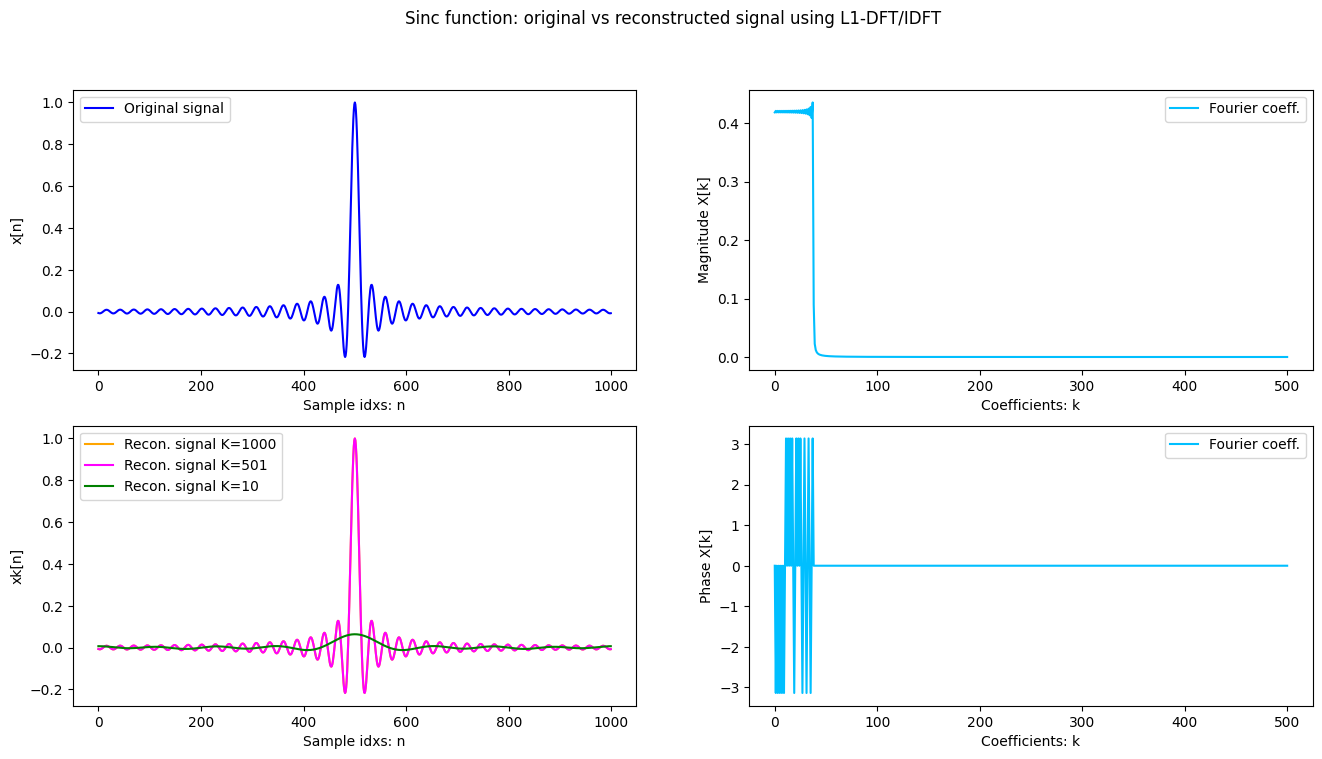

In [ ]:
# frequency
f = 12
# number of samples
N = 1000

# original signal
n = np.arange(N)
x = np.sinc(2 * np.pi * f * np.linspace(-0.5, 0.5, N, endpoint=False))

# compute dft and reconstruct the signal
c1 = dft_l1(x, K=1000)
c2 = dft_l1(x, K=501)
c3 = dft_l1(x, K=10)

xk1 = idft_l1(c1, N=N, onlyreal=True)
xk2 = idft_l1(c2, N=N, onlyreal=True)
xk3 = idft_l1(c3, N=N, onlyreal=True)

# plot the results
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle("Sinc function: original vs reconstructed signal using L1-DFT/IDFT")

axs[0, 0].plot(n, x, c="blue", label="Original signal")
axs[0, 0].set(xlabel="Sample idxs: n", ylabel="x[n]")
axs[0, 0].legend(loc="upper left")

axs[1, 0].plot(n, xk1, c="orange", label="Recon. signal K=1000")
axs[1, 0].plot(n, xk2, c="magenta", label="Recon. signal K=501")
axs[1, 0].plot(n, xk3, c="green", label="Recon. signal K=10")
axs[1, 0].set(xlabel="Sample idxs: n", ylabel="xk[n]")
axs[1, 0].legend(loc="upper left")

axs[0, 1].plot(n[:501], np.abs(c1[:501]), c="deepskyblue", label="Fourier coeff.")
axs[0, 1].set(xlabel="Coefficients: k", ylabel="Magnitude X[k]")
axs[0, 1].legend(loc="upper right")

axs[1, 1].plot(n[:501], np.angle(c1[:501]), c="deepskyblue", label="Fourier coeff.")
axs[1, 1].set(xlabel="Coefficients: k", ylabel="Phase X[k]")
axs[1, 1].legend(loc="upper right")

plt.show()

2025-01-21 10:44:49,451 | INFO | __main__:dft_l1 - Start -> K=10, max_iters=10, eps=1e-06
2025-01-21 10:44:49,718 | INFO | __main__:dft_l1 - End -> iter=10, convergency=0.0018, min_abs_loss=0.0, avg_abs_loss=0.046, max_abs_loss=0.5456


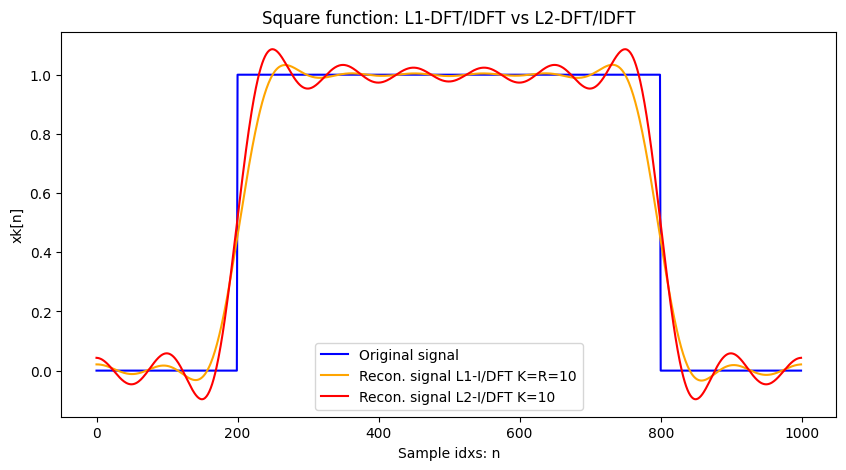

In [ ]:
# number of samples
N = 1000

# original signal
n = np.arange(N)
x = np.array([0] * (N//5) + [1] * (3*N//5) + [0] * (N//5))

# compute dft and reconstruct the signal
c1 = dft_l1(x, K=10, max_iters=10)
c2 = np.fft.fft(x) * np.array([1] * (10) + [0] * (N-19) + [1] * (9))

xk1 = idft_l1(c1, N=N, onlyreal=True)
xk2 = np.real(np.fft.ifft(c2))

# plot the results
plt.figure(figsize=(10, 5))
plt.title("Square function: L1-DFT/IDFT vs L2-DFT/IDFT")
plt.plot(n, x, c="blue", label="Original signal")
plt.plot(n, xk1, c="orange", label="Recon. signal L1-I/DFT K=R=10")
plt.plot(n, xk2, c="red", label="Recon. signal L2-I/DFT K=10")
plt.xlabel("Sample idxs: n")
plt.ylabel("xk[n]")
plt.legend(loc="lower center")
plt.show()

## ECG decomposition

In [ ]:
# download dataset
!wget -r -N -c -np https://physionet.org/files/ludb/1.0.1/
DATAPATH = "/content/physionet.org/files/ludb/1.0.1/data/"

In [ ]:
s = ECG(DATAPATH, "122")

n = np.arange(s.size)
x = s.get_p_signal(ECG.Lead.AVF)

idxs = s.t_waves(ECG.Lead.AVF)

c = dft_l1(x, K=70, max_iters=100)
xk = idft_l1(c, N=s.size, onlyreal=True)

In [ ]:
c2 = dft_l1(x, K=64, max_iters=100)
xk2 = idft_l1(c2, N=s.size, onlyreal=True)

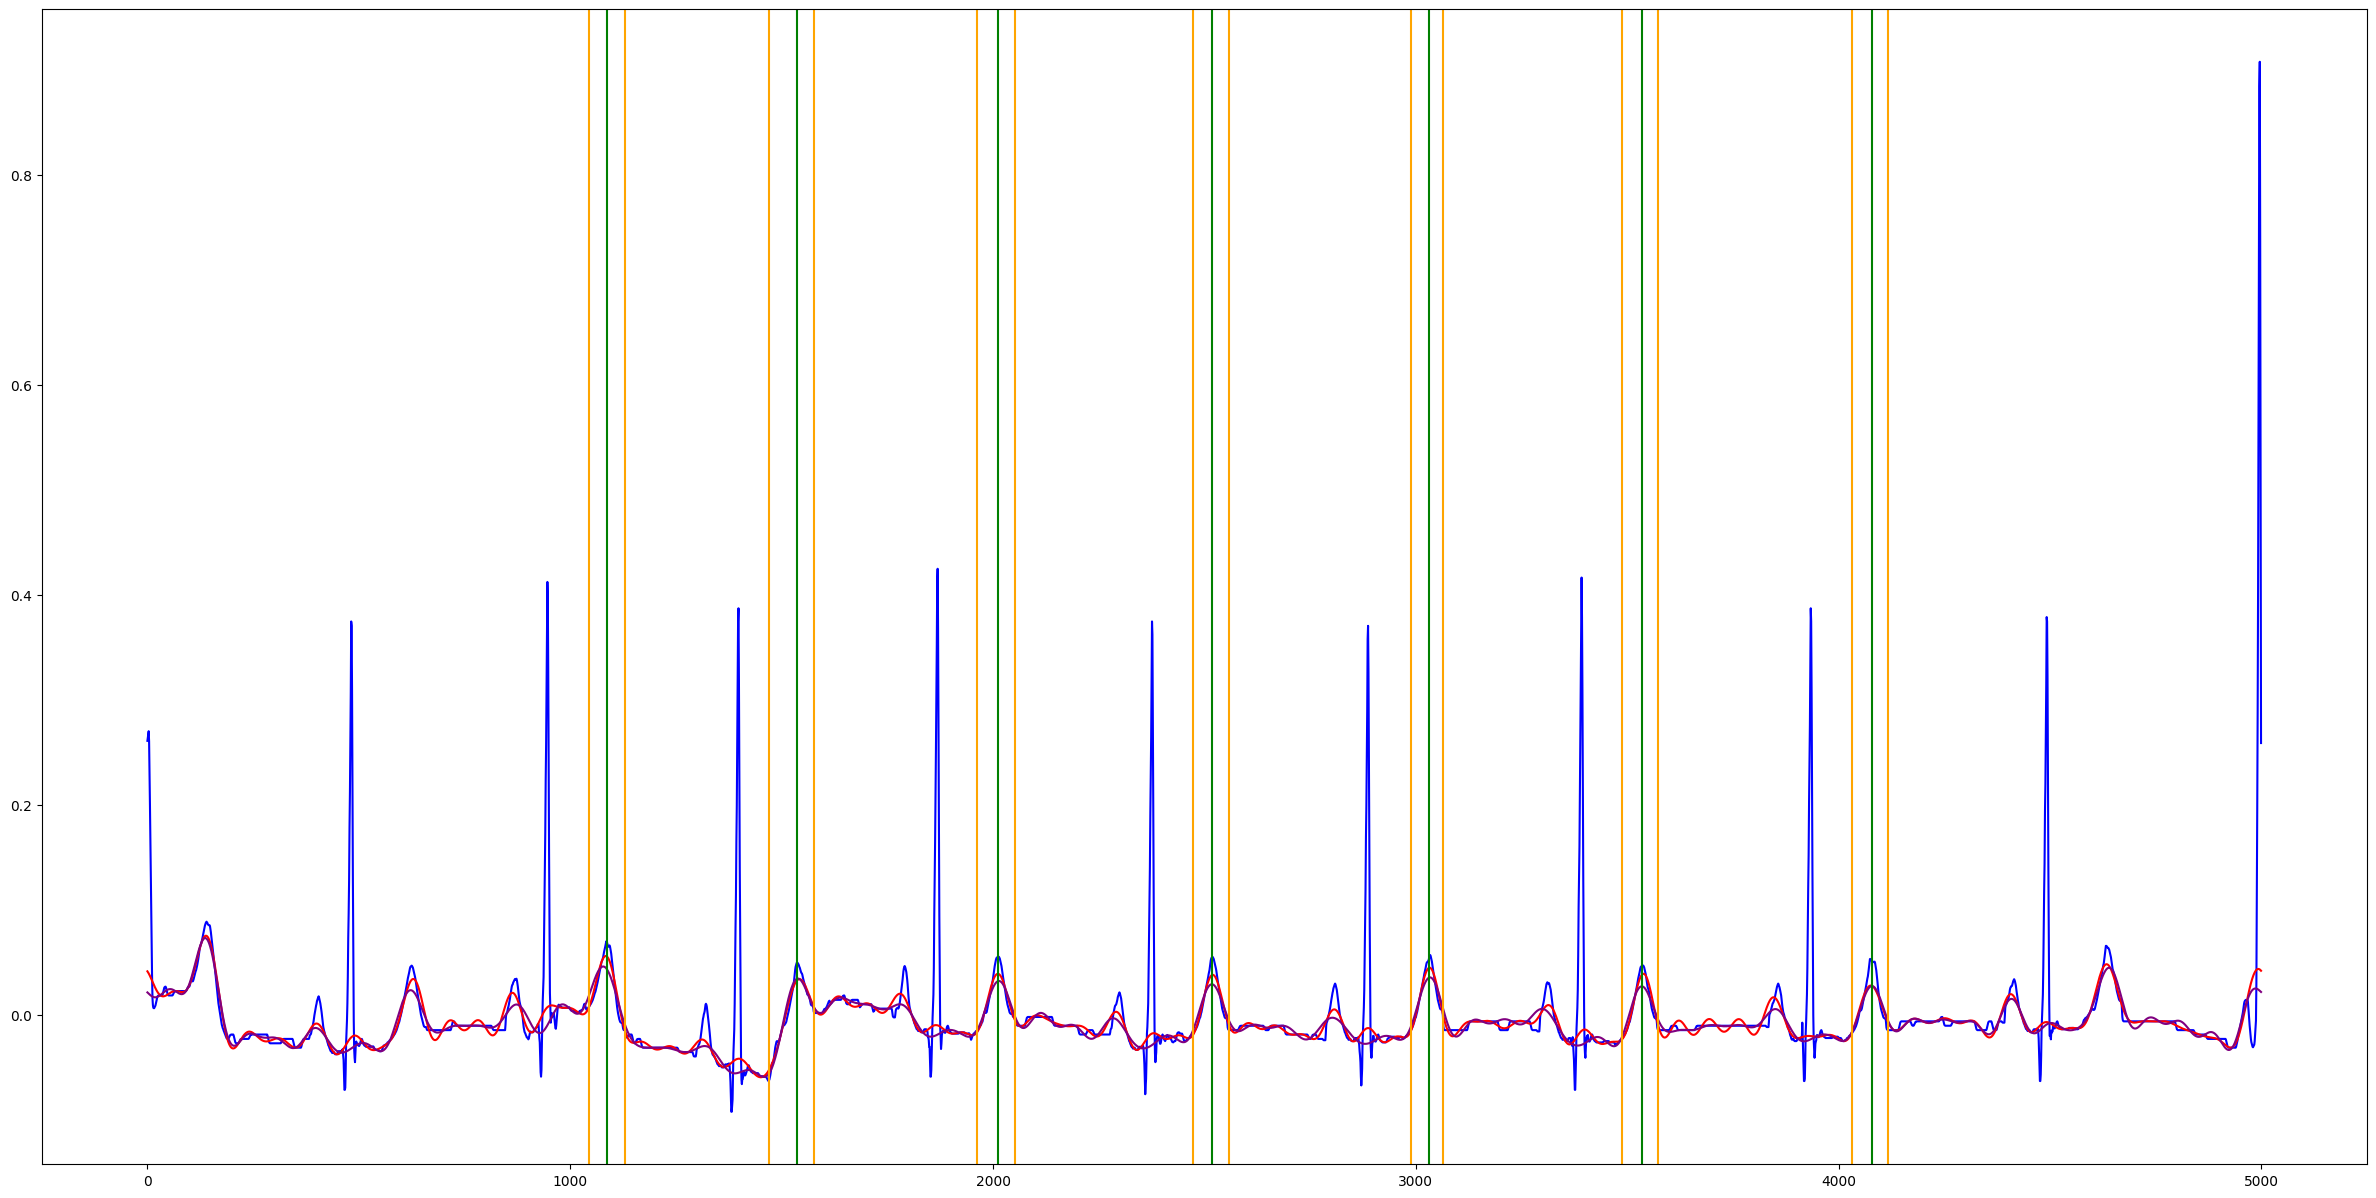

In [38]:
plt.figure(figsize=(30, 15))
plt.plot(n, x, c="blue")
plt.plot(n, xk, c="red")
plt.plot(n, xk2, c="purple")
for i in range(len(idxs)):
    plt.axvline(x=idxs[i, 0], c="orange")
    plt.axvline(x=idxs[i, 1], c="green")
    plt.axvline(x=idxs[i, 2], c="orange")
plt.show()